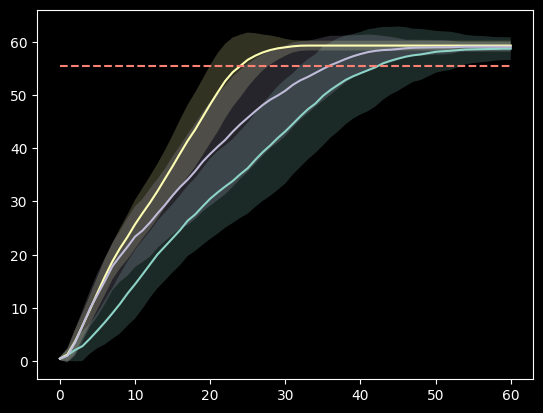

In [7]:
from new_tools import reward, no_collision, projection
import numpy as np
from Adaptor import Adaptor_rte, Combined_adaptor_xy, Combined_adaptor_arc
import math
import matplotlib.pyplot as plt

coor_x = np.load("coor_x.npy")
coor_y = np.load("coor_y.npy")
coor_v = np.load("coor_v.npy")
coor_w = np.load("coor_w.npy")
coor_phi = np.load("coor_phi.npy")
baselines = np.load("filtered_baseline.npy")
case = np.load("f=0.85_s=0.9_dmg1.npy")

# case = np.load("../adaptation/f=0.73_s=0.92_dmg2.npy")
# case = np.load("../adaptation/f=0.88_s=0.76_dmg3.npy")
# case = np.load("../adaptation/f=0.95_s=0.95_dmg0.npy")
budget = 60
np.random.seed(111)
starting_x = np.random.uniform(0, 1, 100)
starting_y = np.random.uniform(-1, 1, 100)
starting_theta = np.random.normal(0, 0.5236, 100)

# # Oracle
# oracle_data = np.zeros((100, budget + 1, 2))

# for r in range(100):
#     state_x = starting_x[r]
#     state_y = starting_y[r]
#     state_theta = starting_theta[r]
#     outcomes = np.zeros((len(baselines), 2), dtype=np.float32)

#     positions = np.zeros((budget + 1, 2), dtype=np.float32)
#     positions[0] = state_x, state_y

#     i = 0
#     invalid_moves = []
#     while i < budget:   
#         R_matrix = np.array([
#             [math.cos(state_theta), -math.sin(state_theta)],
#             [math.sin(state_theta), math.cos(state_theta)]
#         ], dtype=np.float32)

#         predicted_x, predicted_y = case[:, :2].T # damage
#         predicted_x = predicted_x.reshape(-1, 1)
#         predicted_y = predicted_y.reshape(-1, 1)

#         outcomes[:, 0] = predicted_x[:, 0]
#         outcomes[:, 1] = predicted_y[:, 0]
#         outcomes = outcomes @ R_matrix.T
#         outcomes[:, 0] += state_x
#         outcomes[:, 1] += state_y

#         rewards = reward((state_x, state_y), outcomes)

#         next_action_index = np.argmax(rewards)

#         true_x , true_y, true_v, true_w, true_phi = case[next_action_index]
#         new_x = math.cos(state_theta)*true_x - math.sin(state_theta)*true_y + state_x
#         new_y = math.sin(state_theta)*true_x + math.cos(state_theta)*true_y + state_y


#         if no_collision((state_x, state_y), (new_x, new_y)):
#             state_x = new_x
#             state_y = new_y
#             state_theta += 4*true_w
#             positions[i + 1] = state_x, state_y
#         else:
#             positions[i + 1: i+3] = state_x, state_y
#             i += 1
        

#         if state_y > 12.91 and state_x < -2:
#             positions[i + 1:] = state_x, state_y
#             break
#         i += 1
    
#     oracle_data[r] = positions


# orcale_projections = [projection(i[:, 0], i[:, 1]) for i in oracle_data]
# orcale_projections = np.vstack(orcale_projections)
# orcale_mean = np.mean(orcale_projections, axis=0)
# orcale_std = np.std(orcale_projections, axis=0)
# plt.fill_between(np.arange(budget + 1), orcale_mean - orcale_std, orcale_mean + orcale_std, alpha=0.2)
# plt.plot(np.arange(budget + 1), orcale_mean)

# # plt.plot(np.arange(budget + 1), np.zeros(budget + 1)+55.38624, linestyle="--")
# # plt.show()






# RTE
rte_data = np.zeros((100, budget + 1, 2))
rte_hit_count = np.zeros(100)
for r in range(100):
    adaptor_rte = Adaptor_rte(v=0.5)
    state_x = starting_x[r]
    state_y = starting_y[r]
    state_theta = starting_theta[r]
    outcomes = np.zeros((len(baselines), 2), dtype=np.float32)

    positions = np.zeros((budget + 1, 2), dtype=np.float32)
    positions[0] = state_x, state_y

    i = 0
    invalid_moves = []
    while i < budget:    
        R_matrix = np.array([
            [math.cos(state_theta), -math.sin(state_theta)],
            [math.sin(state_theta), math.cos(state_theta)]
        ], dtype=np.float32)

        predicted_x, predicted_y = adaptor_rte.predict(baselines[:, :2])

        outcomes[:, 0] = predicted_x[:, 0]
        outcomes[:, 1] = predicted_y[:, 0]
        outcomes = outcomes @ R_matrix.T
        outcomes[:, 0] += state_x
        outcomes[:, 1] += state_y

        rewards = reward((state_x, state_y), outcomes)

        for action_index in np.argsort(-rewards):
            if action_index not in invalid_moves:
                next_action_index = action_index
                break
        else:
            raise Exception("stuck")

        true_x , true_y, true_v, true_w, true_phi = case[next_action_index]
        new_x = math.cos(state_theta)*true_x - math.sin(state_theta)*true_y + state_x
        new_y = math.sin(state_theta)*true_x + math.cos(state_theta)*true_y + state_y

        step_data = np.zeros((2, 3))
        step_data[:, 0] = baselines[next_action_index, 0]
        step_data[:, 1] = baselines[next_action_index, 1]
        step_data[0, 2] = true_x - baselines[next_action_index, 0]
        step_data[1, 2] = true_y - baselines[next_action_index, 1]
        adaptor_rte.read_data(step_data)

        if no_collision((state_x, state_y), (new_x, new_y)):
            state_x = new_x
            state_y = new_y
            state_theta += 4*true_w
            positions[i + 1] = state_x, state_y
            invalid_moves = []
        else:
            invalid_moves.append(next_action_index)
            positions[i + 1: i+3] = state_x, state_y
            rte_hit_count[r] += 1
            i += 1
        
        if state_y > 12.91 and state_x < -2:
            positions[i + 1:] = state_x, state_y
            break
        i += 1
    
    rte_data[r] = positions


rte_projections = [projection(i[:, 0], i[:, 1]) for i in rte_data]
rte_projections = np.vstack(rte_projections)
rte_mean = np.mean(rte_projections, axis=0)
rte_std = np.std(rte_projections, axis=0)
plt.fill_between(np.arange(budget + 1), rte_mean - rte_std, rte_mean + rte_std, alpha=0.2)
plt.plot(np.arange(budget + 1), rte_mean)

# plt.plot(np.arange(budget + 1), np.zeros(budget + 1)+55.38624, linestyle="--")
# plt.show()






# XY_Adaptor
xy_data = np.zeros((100, budget + 1, 2))
xy_hit_count = np.zeros(100)

for r in range(100):
    adaptor_xy = Combined_adaptor_xy()
    adaptor_xy.load("combined_xy")
    state_x = starting_x[r]
    state_y = starting_y[r]
    state_theta = starting_theta[r]
    outcomes = np.zeros((len(baselines), 2), dtype=np.float32)

    positions = np.zeros((budget + 1, 2), dtype=np.float32)
    positions[0] = state_x, state_y

    i = 0
    invalid_moves = []
    while i < budget:    
        R_matrix = np.array([
            [math.cos(state_theta), -math.sin(state_theta)],
            [math.sin(state_theta), math.cos(state_theta)]
        ], dtype=np.float32)

        predicted_x, predicted_y = adaptor_xy.predict((coor_x, coor_y), baselines.T)

        outcomes[:, 0] = predicted_x[:, 0]
        outcomes[:, 1] = predicted_y[:, 0]
        outcomes = outcomes @ R_matrix.T
        outcomes[:, 0] += state_x
        outcomes[:, 1] += state_y

        rewards = reward((state_x, state_y), outcomes)

        for action_index in np.argsort(-rewards):
            if action_index not in invalid_moves:
                next_action_index = action_index
                break
        else:
            raise Exception("stuck")

        true_x, true_y, true_v, true_w, true_phi = case[next_action_index]
        
        new_x = math.cos(state_theta)*true_x - math.sin(state_theta)*true_y + state_x
        new_y = math.sin(state_theta)*true_x + math.cos(state_theta)*true_y + state_y


        coor = np.vstack((coor_x[next_action_index], coor_y[next_action_index]))
        baseline = baselines[next_action_index].reshape(-1, 1)
        result = case[next_action_index].reshape(-1, 1)
        adaptor_xy.read_data(coor, baseline, result)

        if no_collision((state_x, state_y), (new_x, new_y)):
            state_x = new_x
            state_y = new_y
            state_theta += 4*true_w
            positions[i + 1] = state_x, state_y
            invalid_moves = [] # clear
        else:
            invalid_moves.append(next_action_index)
            positions[i + 1: i+3] = state_x, state_y
            xy_hit_count[r] += 1

            i += 1
        

        if state_y > 12.91 and state_x < -2:
            positions[i + 1:] = state_x, state_y
            break
        i += 1
    
    xy_data[r] = positions


xy_projections = [projection(i[:, 0], i[:, 1]) for i in xy_data]
xy_projections = np.vstack(xy_projections)
xy_mean = np.mean(xy_projections, axis=0)
xy_std = np.std(xy_projections, axis=0)
plt.fill_between(np.arange(budget + 1), xy_mean - xy_std, xy_mean + xy_std, alpha=0.2)
plt.plot(np.arange(budget + 1), xy_mean)





# ARC_Adaptor
arc_data = np.zeros((100, budget + 1, 2))
arc_hit_count = np.zeros(100)

for r in range(100):
    adaptor_arc = Combined_adaptor_arc()
    adaptor_arc.load("combined_arc")
    state_x = starting_x[r]
    state_y = starting_y[r]
    state_theta = starting_theta[r]
    outcomes = np.zeros((len(baselines), 2), dtype=np.float32)

    positions = np.zeros((budget + 1, 2), dtype=np.float32)
    positions[0] = state_x, state_y

    i = 0
    invalid_moves = []
    # last_invalid_outcome = []
    # hit = 0

    while i < budget:    
        R_matrix = np.array([
            [math.cos(state_theta), -math.sin(state_theta)],
            [math.sin(state_theta), math.cos(state_theta)]
        ], dtype=np.float32)

        predicted_x, predicted_y = adaptor_arc.predict((coor_v, coor_w, coor_phi), baselines.T)

        outcomes[:, 0] = predicted_x[:, 0]
        outcomes[:, 1] = predicted_y[:, 0]
        outcomes = outcomes @ R_matrix.T
        outcomes[:, 0] += state_x
        outcomes[:, 1] += state_y

        rewards = reward((state_x, state_y), outcomes)

        # dangerous_moves = []
        # if last_invalid_outcome:
        #     dists = np.min(np.sqrt(np.sum(np.square(outcomes[:, :, None] - np.hstack(last_invalid_outcome)[None, :, :]), axis=1)), axis=-1)
        #     for index, dist in enumerate(dists):
        #         if dist < 1:
        #             dangerous_moves.append(index)

        for action_index in np.argsort(-rewards):
            if action_index not in invalid_moves:
                next_action_index = action_index
                break
        else:
            raise Exception("stuck")

        true_x, true_y, true_v, true_w, true_phi = case[next_action_index]
        
        new_x = math.cos(state_theta)*true_x - math.sin(state_theta)*true_y + state_x
        new_y = math.sin(state_theta)*true_x + math.cos(state_theta)*true_y + state_y


        coor = np.vstack((coor_v[next_action_index], coor_w[next_action_index], coor_phi[next_action_index]))
        baseline = baselines[next_action_index].reshape(-1, 1)
        result = case[next_action_index].reshape(-1, 1)
        adaptor_arc.read_data(coor, baseline, result)

        if no_collision((state_x, state_y), (new_x, new_y)):
            # hit = 0
            state_x = new_x
            state_y = new_y
            state_theta += 4*true_w
            positions[i + 1] = state_x, state_y
            invalid_moves = [] # clear
            # last_invalid_outcome = []
        else:
            # if hit:
                # print(np.array([[new_x, new_y]], dtype=np.float32), outcomes[next_action_index])
                # print(hit + 1)
                # print("filtered amount:", len(invalid_moves))
            # hit += 1
            invalid_moves.append(next_action_index)
            # last_invalid_outcome.append(np.array([[new_x], [new_y]], dtype=np.float32))
            positions[i + 1: i+3] = state_x, state_y
            arc_hit_count[r] += 1

            i += 1
        

        if state_y > 12.91 and state_x < -2:
            positions[i + 1:] = state_x, state_y
            break
        i += 1
    
    arc_data[r] = positions


arc_projections = [projection(i[:, 0], i[:, 1]) for i in arc_data]
arc_projections = np.vstack(arc_projections)
arc_mean = np.mean(arc_projections, axis=0)
arc_std = np.std(arc_projections, axis=0)
plt.fill_between(np.arange(budget + 1), arc_mean - arc_std, arc_mean + arc_std, alpha=0.2)
plt.plot(np.arange(budget + 1), arc_mean)





# plt.plot(np.arange(budget + 1), np.zeros(budget + 1)+55.38624, linestyle="--")
plt.plot(np.arange(budget + 1), np.zeros(budget + 1)+55.529, linestyle="--")
plt.show()




In [8]:
print(np.mean(rte_hit_count))
print(np.mean(xy_hit_count))
print(np.mean(arc_hit_count))

# 4.29
# 2.24
# 6.41

4.29
2.24
6.41
